In [1]:
import cv2
import numpy as np
import pandas as pd
import nibabel as nib
import tensorflow as tf
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import sys
import shutil
from pathlib import Path
from typing import Union, List

sys.path.append("..")

from models.pix2pix import Generator, Discriminator
from models.cyclegan import CasnetGenerator, Generator as CycleganGenerator, Discriminator as CycleganDiscriminator
from run_management import get_path_of_directory_with_id
from preprocessing import min_max_normalization, ct_denormalization, window_image

tf.get_logger().setLevel("ERROR")

2023-08-04 14:45:04.418287: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-04 14:45:05.290274: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Utils

(148, 158, 116, 133)

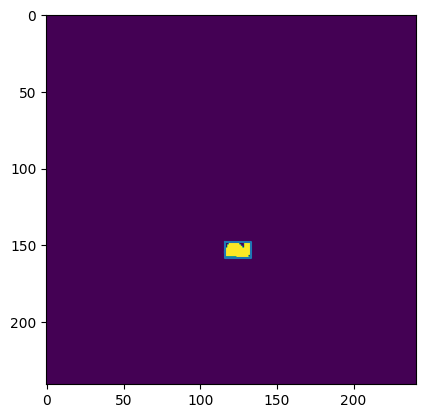

In [38]:
plt.imshow(mask_arr[..., 0])
# draw xmin, xmax, ymin, ymax
plt.plot([ymin, ymin, ymax, ymax, ymin], [xmin, xmax, xmax, xmin, xmin])


In [65]:
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

In [2]:
def ones_normalization(x):
    return (x - 0.5) * 2.0


def ones_back_normalization(x):
    return (x / 2.0) + 0.5


def min_max_back_normalization(x, x_min, x_max):
    return (x * (x_max - x_min)) + x_min


def compute_metrics(real_image, fake_image):
    return {
        "psnr": tf.image.psnr(real_image, fake_image, max_val=1.0).numpy(),
        "ssim": tf.image.ssim(real_image, fake_image, max_val=1.0, filter_size=4).numpy(),
        "ssim_multiscale": tf.image.ssim_multiscale(
            real_image, fake_image, max_val=1.0, filter_size=4
        ).numpy(),
    }
    # distance = real_image.max() - real_image.min()
    # return {
    #     "psnr": psnr(real_image, fake_image, data_range=distance),
    #     "ssim": ssim(real_image, fake_image, data_range=distance),
    # }



def compute_bbox_for_mask(mask):
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax


def load_models_pix2pix(weights_dir, out_channels, out_activation):
    generator = Generator(out_channels, out_activation)
    discriminator = Discriminator()

    generator_optimizer = tf.keras.optimizers.Adam(1e-5, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(1e-5, beta_1=0.5)

    ckpt = tf.train.Checkpoint(
        generator_optimizer=generator_optimizer,
        discriminator_optimizer=discriminator_optimizer,
        generator=generator,
        discriminator=discriminator,
    )
    ckpt.restore(tf.train.latest_checkpoint(weights_dir))
    return generator, discriminator


def load_models_cyclegan(weights_dir, out_channels, out_activation, use_casnet=False):
    if use_casnet:
        generator_f = CasnetGenerator(
            (256, 256, 1), out_channels=out_channels, out_activation=out_activation
        )
        generator_g = CasnetGenerator(
            (256, 256, 1), out_channels=out_channels, out_activation=out_activation
        )
    else:
        generator_f = CycleganGenerator(
            (256, 256, 1), out_channels=out_channels, out_activation=out_activation
        )
        generator_g = CycleganGenerator(
            (256, 256, 1), out_channels=out_channels, out_activation=out_activation
        )
    discriminator_x = CycleganDiscriminator((256, 256, 1))
    discriminator_y = CycleganDiscriminator((256, 256, 1))

    generator_g_optimizer = tf.keras.optimizers.Adam(1e-5, beta_1=0.5)
    generator_f_optimizer = tf.keras.optimizers.Adam(1e-5, beta_1=0.5)
    discriminator_x_optimizer = tf.keras.optimizers.Adam(1e-5, beta_1=0.5)
    discriminator_y_optimizer = tf.keras.optimizers.Adam(1e-5, beta_1=0.5)

    ckpt = tf.train.Checkpoint(
        generator_g=generator_g,
        generator_f=generator_f,
        discriminator_x=discriminator_x,
        discriminator_y=discriminator_y,
        generator_g_optimizer=generator_g_optimizer,
        generator_f_optimizer=generator_f_optimizer,
        discriminator_x_optimizer=discriminator_x_optimizer,
        discriminator_y_optimizer=discriminator_y_optimizer,
    )
    ckpt.restore(tf.train.latest_checkpoint(weights_dir))
    return generator_g, discriminator_y


def compute_metrics_for_patients(
    patients_dirs: List[Union[str, Path]],
    experiment_ids: List[Union[str, int]],
    results_dir: Union[str, Path] = "results",
):
    metrics = ["psnr", "ssim"] #, "ssim_multiscale"
    for experiment_id in experiment_ids:
        experiment_dir = Path(
            get_path_of_directory_with_id(experiment_id, results_dir=results_dir)
        )
        weights_dir = experiment_dir / "weights"
        if "pix2pix" in experiment_dir.name:
            generator, discriminator = load_models_pix2pix(weights_dir, 1, "sigmoid")
            architecture_name = "pix2pix"
        elif "cyclegan" in experiment_dir.name:
            generator, discriminator = load_models_cyclegan(weights_dir, 1, "sigmoid", use_casnet=False)
            architecture_name = "cyclegan"
        elif "casnet" in experiment_dir.name:
            generator, discriminator = load_models_cyclegan(weights_dir, 1, "sigmoid", use_casnet=True)
            architecture_name = "casnet"
        elif "unet" in experiment_dir.name:
            raise NotImplementedError("load models for Unet has not been implemented.")
            architecture_name = "unet"

        metrics_dict = {"patient_id": [], "slice_index": [], "num_lesion_pixels": []}
        metrics_dict = {**metrics_dict, **{metric: [] for metric in metrics}}
        metrics_dict = {
            **metrics_dict,
            **{f"{metric}_lesion": [] for metric in metrics},
        }
        for patient_dir in tqdm(
            patients_dirs, desc=f"Predicting for patients of experiment {experiment_id} with {architecture_name}"
        ):
            if isinstance(patient_dir, str):
                patient_dir = Path(patient_dir)

            patient_id = patient_dir.name
            adc_path = patient_dir / f"{patient_id}_adc.nii.gz"
            ncct_path = patient_dir / f"{patient_id}_ncct.nii.gz"
            mask_path = patient_dir / f"masks/{patient_id}_r1_mask.nii.gz"

            ncct = nib.load(ncct_path)
            ncct_arr = ncct.get_fdata()
            ncct_arr_win = window_image(ncct_arr, 40, 80)
            ncct_min, ncct_max = np.min(ncct_arr), np.max(ncct_arr)
            ncct_arr = min_max_normalization(ncct_arr).astype(np.float32)
            ncct_arr_res = tf.image.resize(ncct_arr, [256, 256]).numpy()
            # ncct_arr_win = min_max_normalization(ncct_arr_win)
            # ncct_arr_win_res = tf.image.resize(ncct_arr_win, [256, 256]).numpy()

            adc = nib.load(adc_path)
            adc_arr = adc.get_fdata()
            adc_min, adc_max = np.min(adc_arr), np.max(adc_arr)
            adc_arr = min_max_normalization(adc_arr).astype(np.float32)
            adc_arr_res = tf.image.resize(adc_arr, [256, 256]).numpy()

            # Compute the fake image.
            adc_fake_arr_res = generator.predict(
                ncct_arr_res.transpose(2, 0, 1)[..., np.newaxis], verbose=0
            )
            adc_fake_arr_res = adc_fake_arr_res.transpose(1, 2, 0, 3)[..., 0]

            # Reshape back to original shape.
            adc_fake_arr = tf.image.resize(adc_fake_arr_res, adc_arr.shape[:2]).numpy()

            # nifties.
            save_dir = experiment_dir / "predictions/test" / patient_id
            save_dir.mkdir(parents=True, exist_ok=True)
            adc_fake_arr_back = min_max_back_normalization(adc_fake_arr, adc_min, adc_max)
            adc_fake = nib.Nifti1Image(
                adc_fake_arr_back.astype(np.float32), adc.affine, adc.header
            )
            nib.save(adc_fake, save_dir / f"{patient_id}_adc_fake.nii.gz")
            shutil.copy(ncct_path, save_dir / f"{patient_id}_ncct.nii.gz")
            shutil.copy(adc_path, save_dir / f"{patient_id}_adc.nii.gz")

            # Compute metrics.
            if mask_path.exists():
                shutil.copy(mask_path, save_dir / f"{patient_id}_r1_mask.nii.gz")
                mask = nib.load(mask_path)
                mask_arr = mask.get_fdata()
                assert mask_arr.shape == adc_arr.shape

        #     for i in range(adc_fake_arr.shape[-1]):
        #         print(adc_arr[..., i : i + 1].shape, adc_fake_arr[..., i : i + 1].shape)
        #         slice_metrics = compute_metrics(
        #             adc_arr[..., i : i + 1], adc_fake_arr[..., i : i + 1]
        #         )
        #         metrics_dict["patient_id"].append(patient_id)
        #         metrics_dict["slice_index"].append(i)
                
        #         # Compute the metrics on the whole images.
        #         for metric in metrics:
        #             metrics_dict[metric].append(slice_metrics[metric])

        #         # Compute the metrics that require a mask.
        #         if mask_path.exists():
        #             metrics_dict["num_lesion_pixels"].append(
        #                 np.count_nonzero(mask_arr[..., i : i + 1])
        #             )
        #             slice_has_lesion = np.any(mask_arr[..., i : i + 1])
        #             if slice_has_lesion:
        #                 ymin, ymax, xmin, xmax = compute_bbox_for_mask(mask_arr[..., i : i + 1])
                        
        #                 # Ensure that your images are at least 20x20.
        #                 ydiff = ymax - ymin
        #                 xdiff = xmax - xmin
        #                 print(f"ydiff: {ydiff}", end=" ")
        #                 if ydiff < 20:
        #                     ymin -= ((20 - ydiff)//2)
        #                     ymax += ((20 - ydiff)//2) + 1
        #                     print(f"ydiff: {ymax - ymin}", end=" ")
        #                 print(f"ydiff: {xdiff}", end=" ")
        #                 if xdiff < 20:
        #                     xmin -= ((20 - xdiff)//2)
        #                     xmax += ((20 - xdiff)//2)
        #                     print(f"ydiff: {xmax - xmin}", end=" ")

        #                 lesion_slice_metrics = compute_metrics(
        #                     adc_arr[ymin:ymax, xmin:xmax, i : i + 1], 
        #                     adc_fake_arr[ymin:ymax, xmin:xmax, i : i + 1]
        #                 )
        #                 for metric in metrics:
        #                     metrics_dict[f"{metric}_lesion"].append(lesion_slice_metrics[metric])
        #             else:
        #                 for metric in metrics:
        #                     metrics_dict[f"{metric}_lesion"].append(np.nan)
        #         else:
        #             metrics_dict["num_lesion_pixels"].append(0)
        #             for metric in metrics:
        #                 metrics_dict[f"{metric}_lesion"].append(np.nan)
                    

        # print(str(experiment_dir / "evaluation/test_metrics_2.csv"))
        # pd.DataFrame(metrics_dict).to_csv(
        #     str(experiment_dir / "evaluation/test_metrics_2.csv"), index=False
        # )


def save_translations(save_dir: Union[str, Path], generator: tf.keras.Model):
    save_dir = Path(save_dir) if isinstance(save_dir, str) else save_dir
    figures_dir = save_dir / "figures"
    figures_dir.mkdir(exist_ok=True)
    niftis_dir = save_dir / "niftis"
    niftis_dir.mkdir(exist_ok=True)

    examples_dict = {
        "train_026": 45,
        "train_035": 45,
        "train_044": 99,
        "train_058": 104,
        "test_022": 69,
        "test_037": 10,
    }
    for i, (patient_id, lesion_idx) in enumerate(examples_dict.items()):
        fig, axs = plt.subplots(figsize=(20, 20))
        examples_dir = Path().absolute().parent / "examples"
        adc_path = examples_dir / f"{patient_id}/{patient_id}_adc.nii.gz"
        ncct_path = examples_dir / f"{patient_id}/{patient_id}_ncct.nii.gz"
        mask_path = examples_dir / f"{patient_id}/masks/{patient_id}_r1_mask.nii.gz"

        ncct = nib.load(ncct_path)
        ncct_arr = ncct.get_fdata()
        ncct_arr_win = window_image(ncct_arr, 40, 80)
        ncct_min, ncct_max = np.min(ncct_arr), np.max(ncct_arr)
        ncct_arr = min_max_normalization(ncct_arr)
        ncct_arr_res = tf.image.resize(ncct_arr, [256, 256]).numpy()
        ncct_arr_win = min_max_normalization(ncct_arr_win)
        ncct_arr_win_res = tf.image.resize(ncct_arr_win, [256, 256]).numpy()

        adc = nib.load(adc_path)
        adc_arr = adc.get_fdata()
        adc_min, adc_max = np.min(adc_arr), np.max(adc_arr)
        adc_arr = min_max_normalization(adc_arr)
        adc_arr_res = tf.image.resize(adc_arr, [256, 256]).numpy()

        # Compute the fake image.
        adc_fake_arr = generator.predict(
            ncct_arr_res.transpose(2, 0, 1)[..., np.newaxis], verbose=0
        )
        adc_fake_arr = adc_fake_arr.transpose(1, 2, 0, 3)[..., 0]

        # Create the plot.
        idxs = np.array([lesion_idx + (i * 6) for i in range(-1, 2)])
        metrics_slices = []
        ncct_slices, adc_fake_slices, adc_slices = [], [], []
        for idx in idxs:
            ncct_slices.append(np.rot90(ncct_arr_win_res[..., idx]))
            adc_fake_slices.append(np.rot90(adc_fake_arr[..., idx]))
            adc_slices.append(np.rot90(adc_arr_res[..., idx]))
            metrics = compute_metrics(
                adc_arr_res[..., idx : idx + 1], adc_fake_arr[..., idx : idx + 1]
            )
            metrics_slices.append(
                "PSNR: {:.3f}, SSIM: {:.3f}".format(metrics["psnr"], metrics["ssim"])
            )
        ncct_plot = np.vstack(ncct_slices)
        adc_fake_plot = np.vstack(adc_fake_slices)
        adc_plot = np.vstack(adc_slices)
        final_plot = np.hstack([ncct_plot, adc_fake_plot, adc_plot])
        axs.imshow(final_plot, cmap="gray")
        axs.annotate(
            "NCCT", (128, 25), ha="center", va="center", fontsize=32, color="white"
        )
        axs.annotate(
            "ADC$_{fake}$",
            (128 + 256 * 1, 25),
            ha="center",
            va="center",
            fontsize=32,
            color="white",
        )
        axs.annotate(
            "ADC",
            (128 + 256 * 2, 25),
            ha="center",
            va="center",
            fontsize=32,
            color="white",
        )
        axs.annotate(
            metrics_slices[0],
            (128 + 256 * 1, 50),
            ha="center",
            va="center",
            fontsize=24,
            color="white",
        )
        axs.annotate(
            metrics_slices[1],
            (128 + 256 * 1, 50 + 256),
            ha="center",
            va="center",
            fontsize=24,
            color="white",
        )
        axs.annotate(
            metrics_slices[2],
            (128 + 256 * 1, 50 + 512),
            ha="center",
            va="center",
            fontsize=24,
            color="white",
        )
        axs.axis("off")
        plt.savefig(
            figures_dir / f"{patient_id}.png", bbox_inches="tight", pad_inches=0
        )
        plt.close()

        # Save the niftis.
        shutil.copy(adc_path, niftis_dir)
        shutil.copy(ncct_path, niftis_dir)
        adc_fake_arr = tf.image.resize(adc_fake_arr, adc_arr.shape[:2]).numpy()
        adc_fake_arr = min_max_back_normalization(adc_fake_arr, adc_min, adc_max)
        adc_fake = nib.Nifti1Image(
            adc_fake_arr.astype(np.float32), adc.affine, adc.header
        )
        nib.save(adc_fake, niftis_dir / f"{patient_id}_adc_fake.nii.gz")


In [4]:
experiment_dir = Path(get_path_of_directory_with_id(14, results_dir="/home/sangohe/projects/lesion-aware-translation/results"))
weights_dir = experiment_dir / "weights"
generator, discriminator = load_models_cyclegan(experiment_dir, 1, "sigmoid", use_casnet=True)

In [5]:
patient_id = "test_022"
examples_dir = Path().absolute().parent / "examples"
adc_path = examples_dir / f"{patient_id}/{patient_id}_adc.nii.gz"
ncct_path = examples_dir / f"{patient_id}/{patient_id}_ncct.nii.gz"
mask_path = examples_dir / f"{patient_id}/masks/{patient_id}_r1_mask.nii.gz"

ncct = nib.load(ncct_path)
ncct_arr = ncct.get_fdata()
ncct_arr_win = window_image(ncct_arr, 40, 80)
ncct_min, ncct_max = np.min(ncct_arr), np.max(ncct_arr)
ncct_arr = min_max_normalization(ncct_arr)
ncct_arr_res = tf.image.resize(ncct_arr, [256, 256]).numpy()
ncct_arr_win = min_max_normalization(ncct_arr_win)
ncct_arr_win_res = tf.image.resize(ncct_arr_win, [256, 256]).numpy()

adc = nib.load(adc_path)
adc_arr = adc.get_fdata()
adc_min, adc_max = np.min(adc_arr), np.max(adc_arr)
adc_arr = min_max_normalization(adc_arr)
adc_arr_res = tf.image.resize(adc_arr, [256, 256]).numpy()

# Compute the fake image.
adc_fake_arr = generator.predict(
    ncct_arr_res.transpose(2, 0, 1)[..., np.newaxis], verbose=0
)
adc_fake_arr = adc_fake_arr.transpose(1, 2, 0, 3)[..., 0]

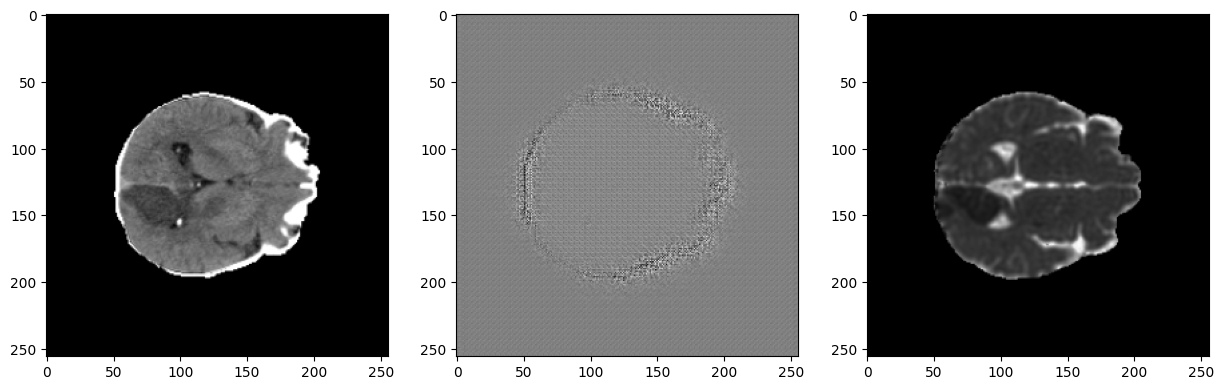

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(ncct_arr_win_res[..., 69], cmap="gray")
axs[1].imshow(adc_fake_arr[..., 69], cmap="gray")
axs[2].imshow(adc_arr_res[..., 69], cmap="gray")


# Compute metrics

In [10]:
patients_txt = "/home/sangohe/projects/lesion-aware-translation/data/APIS_synth-0_5_1_0_3_0_shuffled/test_patients.txt"
patients_dirs = [Path(line.strip()) for line in open(patients_txt, "r").readlines()]

results_dir = "/home/sangohe/projects/lesion-aware-translation/results"
experiment_ids = [26]  # 2 -> dilated weights
#experiment_ids = list(range(3, 9))
compute_metrics_for_patients(patients_dirs, experiment_ids, results_dir)


Predicting for patients of experiment 26:   0%|          | 0/38 [00:00<?, ?it/s]

# Create figures

In [11]:
results_dir = "/home/sangohe/projects/lesion-aware-translation/results"
experiment_ids = [26]
for experiment_id in experiment_ids:
    experiment_dir = Path(get_path_of_directory_with_id(experiment_id, results_dir=results_dir))
    weights_dir = experiment_dir / "weights"
    generator, discriminator = load_models_pix2pix(weights_dir, 1, "sigmoid")
    save_translations(experiment_dir / "evaluation", generator)

NameError: name 'load_models_pix2pix' is not defined

In [ ]:
results_dir = "/home/sangohe/projects/lesion-aware-translation/results"
experiment_ids = [2] # 2 -> dilated weights
for experiment_id in experiment_ids:
    experiment_dir = Path(get_path_of_directory_with_id(experiment_id, results_dir=results_dir))
    weights_dir = experiment_dir / "weights"
    generator, discriminator = load_models_pix2pix(weights_dir, 1, "sigmoid")

# Todos

- [ ] create a plot with the validation samples
- [ ] compute the psnr and ssim for the test samples (and test patches)

# Read the images from different evaluation folders and plot them side by side

In [6]:
results_dir = "/home/sangohe/projects/lesion-aware-translation/results"
experiment_ids = [7, 8]
patient_ids = ["train_026", "train_035", "train_044", "train_058"]

comparison_plots = []
for patient_id in patient_ids:
    figures = []
    for experiment_id in experiment_ids:
        experiment_dir = Path(get_path_of_directory_with_id(experiment_id, results_dir=results_dir))
        figures_dir = experiment_dir / "evaluation" / "figures"
        figure = cv2.imread(str(figures_dir / f"{patient_id}.png"))
        figure = cv2.cvtColor(figure, cv2.COLOR_BGR2RGB)
        figure = np.vstack([np.zeros((100, figure.shape[1], 3)).astype(np.uint8), figure])
        figures.append(figure)
        figures.append(np.ones((figure.shape[0], 10, 3)).astype(np.uint8) * 255)
    figures.pop()
    comparison_plots.append(np.hstack(figures))

figures_dir = Path("/home/sangohe/projects/lesion-aware-translation/figures")
for i, (experiment_id, patient_id, comparison_plot) in enumerate(zip(experiment_ids, patient_ids, comparison_plots)):
    plt.imshow(comparison_plot)
    annotation = experiment_dir.name.split("-")[3]
    annotation = "normal" if not "weights" in annotation else annotation
    plt.annotate("Weights", (256*3, 45), ha="center", va="center", color="white", fontsize=5)
    plt.annotate("Dilated Weights", (256*9, 45), ha="center", va="center", color="white", fontsize=5)
    plt.annotate("None", (256*15, 45), ha="center", va="center", color="white", fontsize=5)
    plt.axis("off")
    plt.savefig(figures_dir / f"{patient_id}_models_comparison_new.png", bbox_inches="tight", pad_inches=0, dpi=500)
    plt.close()

In [7]:
figures_dir = Path("/home/sangohe/projects/lesion-aware-translation/figures")

for patient_id in patient_ids[:-1]:
    figure_path = figures_dir / f"{patient_id}_models_comparison.png"
    figure_path_new = figures_dir / f"{patient_id}_models_comparison_new.png"
    figure = cv2.imread(str(figure_path))
    figure_new = cv2.imread(str(figure_path_new))

    new_figure = np.vstack([figure, (np.ones((5, figure_new.shape[1], 3)) * 255).astype(np.uint8), figure_new])
    cv2.imwrite(str(figures_dir / f"{patient_id}_full_comparison.png"), new_figure)


[ WARN:0@2372.208] global loadsave.cpp:244 findDecoder imread_('/home/sangohe/projects/lesion-aware-translation/figures/train_026_models_comparison.png'): can't open/read file: check file path/integrity


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 3 dimension(s)

In [8]:
np.ones((100, figure_new.shape[1])).shape

(100, 2480)